In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE=0

# Load the data

In [3]:
dat_verdes = pd.read_excel('data/ELK REALES DEF Melanoma_Patients_DataBase.TODOS_VERDE.xlsx')

In [4]:
# Change mistakenly EL-B007 duplicated to EL-B176
dat_verdes.iloc[7,1] = 'EL-B176'

In [5]:
dat_verdes.rename(columns={dat_verdes.columns[28]: 'IFNg', 
                                      dat_verdes.columns[29]: "TGFb",
                                      dat_verdes.columns[1]:'code'}, inplace =True)

In [6]:
#Drop subjects with more than 1 biopsy. Including them would ruin independency of observations
dat_verdes = dat_verdes.drop_duplicates(subset = 'code')

In [7]:
# Interpolate under measure kits sensitivity levels 
# between 0 and the sensitivity of the tests
sens_levels = [1.22, 1.12, 0.18, 1.46, 0.73, 0.61]
np.random.seed(RANDOM_STATE)
for i, cit_name in enumerate(['GM-CSF', 'IL-4', u'IL-6', u'IL-10', 'IL-17A', 'IFNg']):
    foo = dat_verdes.loc[:,cit_name].astype(str).values
    dat_verdes.loc[:,cit_name] = [str(sens_levels[i]*np.random.rand()) if elem.startswith('<') else elem 
                                     for elem in foo]
    dat_verdes.loc[:,cit_name] = pd.to_numeric(dat_verdes.loc[:,cit_name], errors='coerce')

In [8]:
dat_verdes['HIST_AJCC_RES'] = pd.to_numeric(dat_verdes['HIST_AJCC_RES'],  errors='coerce')

In [9]:
# Split in Healthy, melanoma and Nevus Subjects
healthy  = dat_verdes[dat_verdes['HIST_AJCC_RES']==11].copy()
melanoma  = dat_verdes[(dat_verdes['HIST_AJCC_RES']>0)  & 
                           (dat_verdes['HIST_AJCC_RES']<11)].copy()
nevus  = dat_verdes[dat_verdes['HIST_AJCC_RES']==0].copy()

# STATISTIC

In [10]:
from scipy.stats import kruskal,mannwhitneyu, chi2_contingency, shapiro
from statsmodels.stats.multitest import multipletests
from statsmodels.graphics.gofplots import ProbPlot
from functions import bootci, delta

In [11]:
# Check normality of variables
for var in ['GM-CSF', 'IL-4', u'IL-6', u'IL-10', 'IL-17A', 'IFNg',  'TGFb', 'Dermicidina', 'EDAD al Dx']:
    print(shapiro(dat_verdes.loc[:, var].dropna()))

(0.40724968910217285, 2.5311538021482448e-36)
(0.6654210686683655, 3.1785108449398377e-29)
(0.600279688835144, 2.403490040934221e-31)
(0.6253691911697388, 1.4552753599338173e-30)
(0.7246742248535156, 5.454404239897725e-27)
(0.6535303592681885, 1.2358056745787968e-29)
(0.8912935853004456, 8.671293829543374e-18)
(0.8545606136322021, 2.6951795839207434e-19)
(0.971232533454895, 5.559875404514969e-08)


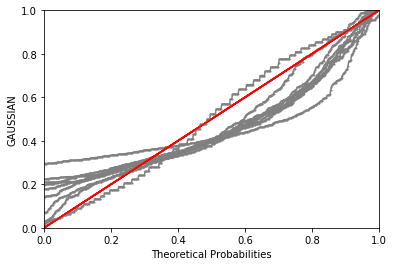

In [12]:
fig, ax = plt.subplots()
for var in ['GM-CSF', 'IL-4', u'IL-6', u'IL-10', 'IL-17A', 'IFNg',  'TGFb', 'Dermicidina', 'EDAD al Dx']: 
    foo=ProbPlot(data=dat_verdes.loc[:,var].dropna().values.astype(float), fit=True)
    foo.ppplot(line='45', ax=ax, fmt='o', linestyle = '-', color = 'gray', markersize=1, ylabel="GAUSSIAN")

### TABLE 2: MELANOMA VERSUS STAGE

In [13]:
np.random.seed(RANDOM_STATE)
for var in ['GM-CSF', 'IL-4', u'IL-6', u'IL-10', 'IL-17A', 'IFNg', 'TGFb', 'Dermicidina']:
    for stage_i in np.arange(1,6):
        case = melanoma.loc[melanoma['HIST_AJCC_RES']==stage_i, var].dropna().values
        l, u = bootci(case, stat=np.median)
        print( 'var = ' + var + ' stage ' + str(stage_i) + ' median= ' + 
              str(np.round(np.median(case),2)) + ' li = ' + str(np.round(l,2)) + ' ui = ' + str(np.round(u,2)))

var = GM-CSF stage 1 median= 108.49 li = 78.96 ui = 163.75
var = GM-CSF stage 2 median= 122.56 li = 107.17 ui = 140.39
var = GM-CSF stage 3 median= 137.86 li = 104.2 ui = 170.74
var = GM-CSF stage 4 median= 84.68 li = 42.66 ui = 116.94
var = GM-CSF stage 5 median= 63.48 li = 18.09 ui = 280.48
var = IL-4 stage 1 median= 27.76 li = 20.07 ui = 37.21
var = IL-4 stage 2 median= 35.95 li = 28.88 ui = 41.5
var = IL-4 stage 3 median= 37.81 li = 28.42 ui = 56.31
var = IL-4 stage 4 median= 52.82 li = 27.86 ui = 63.0
var = IL-4 stage 5 median= 33.33 li = 8.49 ui = 136.3
var = IL-6 stage 1 median= 3.11 li = 2.02 ui = 3.84
var = IL-6 stage 2 median= 3.3 li = 2.91 ui = 3.98
var = IL-6 stage 3 median= 4.27 li = 3.23 ui = 5.46
var = IL-6 stage 4 median= 2.62 li = 1.8 ui = 5.42
var = IL-6 stage 5 median= 4.97 li = 1.11 ui = 6.65
var = IL-10 stage 1 median= 8.29 li = 5.16 ui = 13.15
var = IL-10 stage 2 median= 10.23 li = 7.95 ui = 13.76
var = IL-10 stage 3 median= 11.34 li = 7.38 ui = 16.35
var = IL-10 

In [14]:
# Kruskal wallis on stage
p_stages=[]
for var in ['GM-CSF', 'IL-4', u'IL-6', u'IL-10', 'IL-17A', 'IFNg', 'TGFb', 'Dermicidina']:
    case = [melanoma.loc[melanoma['HIST_AJCC_RES']==stage_i, var].dropna().values \
            for stage_i in np.arange(1,6)]
    _, p = kruskal(*case)
    p_stages.append(p)

_, p_stages_fdr, _, _ = multipletests(p_stages, method="fdr_bh")
print(np.round(p_stages_fdr, 3))

[0.489 0.413 0.413 0.614 0.413 0.413 0.614 0.489]


In [15]:
# mannwhitney only between AJCC I and II (for collapsed table 2)
p_stages=[]
cliffs = []
for var in ['GM-CSF', 'IL-4', u'IL-6', u'IL-10', 'IL-17A', 'IFNg', 'TGFb', 'Dermicidina']:
    case = [melanoma.loc[melanoma['HIST_AJCC_RES']==stage_i, var].dropna().values \
            for stage_i in np.arange(2,4)]
    u, p = mannwhitneyu(*case, alternative='two-sided')
    
    N1N2=float(len(case[0])*len(case[1]))
    delta = 1.0 - 2*u/N1N2
    cliffs.append(delta)
    p_stages.append(p)

_, p_stages_fdr, _, _ = multipletests(p_stages, method="fdr_bh")

for ii, var in enumerate(['GM-CSF', 'IL-4', u'IL-6', u'IL-10', 'IL-17A', 'IFNg',  'TGFb', 'Dermicidina']):
    print( '%s  FDR p-val corrected = %.2f and Cliff delta = %.2f' % (var, p_stages_fdr[ii], cliffs[ii]))

GM-CSF  FDR p-val corrected = 0.96 and Cliff delta = 0.00
IL-4  FDR p-val corrected = 0.45 and Cliff delta = 0.10
IL-6  FDR p-val corrected = 0.44 and Cliff delta = 0.14
IL-10  FDR p-val corrected = 0.73 and Cliff delta = 0.06
IL-17A  FDR p-val corrected = 0.79 and Cliff delta = -0.04
IFNg  FDR p-val corrected = 0.96 and Cliff delta = 0.01
TGFb  FDR p-val corrected = 0.45 and Cliff delta = -0.11
Dermicidina  FDR p-val corrected = 0.73 and Cliff delta = -0.06
